## Clustering and Segmenting NewYork counties to see Covid-19 Impact :
As a part of IBM's Applied Data Science capstone course on coursera, I worked on a Capstone project where I used Four Square API and machine learning algorithm to fetch the required information and have attempted clustering analysis on it. This report consists of three parts: Business Problem and Data Preparation and cleaning, Methodology, Results and discussion and conclusion.

## Business Problem:
As we know, World has been facing an unprecedented threat of Covid-19. While, it has spread and penetrated rapidly into different parts of the globle, in the United States, New York is one of the worst hit state by COVID-19. New York city is at the center of the disaster. According to an article https://ny.eater.com/2020/12/9/22165800/indoor-dining-nyc-coronavirus-spread-robert-mujica by by Tanay Warerkar and Erika Adams,they mentioned that indoor dining at restaurants and bars are currently the fifth or sixth highest category in the city for the spread of the virus, but he did not outline what the top categories pushing the city toward a full-blown second wave of the pandemic. In this capestone project, I have attempted a hit and trial to find out the top categories. For this research, I have taken the most affected counties in New York with a high number of confirmed cases. Furthermore, by using the four-Square API, we will figure out the top 10 common venues with the most foot traffic. After getting this information, I believe,a common man will get a glimpse into one of the cause or possibilty of the rapid spread of this virus.

So, how could be leverage Foursquare location data and machine learning to help us make decision and know more about the cause. This is the problem which I am going to discuss by taking New York as an example. Here in this capstone, we will go through each step of this project and address them seperately. I will first outline the initial data preparation and describe future steps to start the analysis of venues in New York.

### Data Preparation
For this project we need the following data:

1.United states data that contains list of counties of each state with their longitudes and latitudes.  
  Data Source : https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
  
2.Venues in each county of New York
  Data Source: FourSquare APIs
  
  The project would use Four Square API as its primary data gathering source as it has a database of millions of places. Hence, The Four Square data is used to extract the venue data centered around the counties of New York. The venue data includes venue name, venue categories and location coordinates. From these two datasets, required venue categories would be identified and clustered using the k-means clustering algorithms.
  
### Data Cleaning: 
After examining the United States dataset,let's first import some of the libraries that we’ll be using, and set some parameters to make the output easier to read.



In [1]:
import pandas as pd
import urllib
import requests

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
 #libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 79 kB 7.6 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=8bdd20362b9e480c8234f4d0646e0f082625c935f2e471decc3f4e26efe89e38
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium installed
Libraries imported.


### Load and Explore the Dataset
The datasource  is the list of counties(Admin2) of each state of United States with Province state, latitude(lat) and longitude(long_) of each county. Here in New York data set link, Admin2 is the County of each state of United states.Now, load data into pandas dataframe to explore the data. Here We are using urllib.Request Python module for fetching Urls. In this module, HTTP is based on requests and responses - the client makes requests and servers send responses. urllib.request mirrors this with a Request object which represents the HTTP request you are making.Once it’s loaded, we’ll want to do some basic cleaning tasks to remove some information we don’t need that will make our data processing slower.

In [2]:
confirmed_csv_url= "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
urlRequest = urllib.request.Request(confirmed_csv_url)

In [3]:
confirmed_data = urllib.request.urlopen(urlRequest)

In [4]:
confirmed_dataframe = pd.read_csv(confirmed_data, sep = ',', decimal = '.')
confirmed_dataframe.head()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264


The above dataset is from January 2020 to january 2021, but here we are considering only one month festive season data from 11/25/2020 to 12/25/2020

In [5]:
# We are collecting dataset from "" site from 11/25/2020 to 12/18/2020
total_confirmed_cases = []
for i in range (0, 3340):
    sum_nov = 0
    for j in range (25, 30+1):
        day = str(j)
        col = "11/"+day+"/20"
        sum_nov = sum_nov + confirmed_dataframe[col][i]
        
        
    sum_dec = 0
    for j in range (1, 24+1):
        day = str(j)
        col = "12/"+day+"/20"
        sum_dec = sum_dec + confirmed_dataframe[col][i]
    
    total_confirmed_cases.append(sum_nov + sum_dec)


In [6]:
total_confirmed_cases

[96482,
 309224,
 37705,
 41662,
 107162,
 21727,
 38421,
 224930,
 58828,
 34611,
 74250,
 13436,
 55809,
 29615,
 25777,
 84432,
 110156,
 22636,
 12277,
 73719,
 23170,
 161739,
 79942,
 73260,
 168659,
 143588,
 65930,
 229325,
 33339,
 83440,
 40917,
 15228,
 33231,
 29051,
 177322,
 121107,
 1167787,
 24326,
 145977,
 45653,
 255713,
 153006,
 25485,
 24624,
 486435,
 42206,
 48825,
 222246,
 649209,
 27181,
 405411,
 241805,
 0,
 21984,
 41591,
 51224,
 33206,
 72416,
 365289,
 151003,
 19640,
 124068,
 59896,
 447223,
 0,
 126399,
 29984,
 21642,
 46791,
 1186,
 4220,
 577342,
 54062,
 0,
 4518,
 1537,
 3197,
 120382,
 562,
 0,
 27794,
 91474,
 6450,
 16822,
 16352,
 145251,
 7407,
 18277,
 11271,
 0,
 807,
 1817,
 6775,
 366,
 10131,
 5654,
 8606,
 671,
 1509,
 5589,
 0,
 183831,
 144709,
 260759,
 104322,
 74670,
 8906,
 30576,
 7281368,
 240527,
 276636,
 0,
 1470007,
 605134,
 139258,
 45,
 219053,
 634622,
 32083,
 30131,
 48367,
 414459,
 61978,
 19351,
 5135,
 50201,
 38

In our dataset, now I am going to add new column i.e total_confirmed_cases by summing up all the confirmed cases from 11/25 to 12/25.

In [7]:
confirmed_dataframe['total_confirmed_cases'] = total_confirmed_cases

In [8]:
confirmed_dataframe.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,total_confirmed_cases
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,4705,4770,4847,4879,4902,4970,4998,5075,5103,96482
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,14845,15052,15202,15327,15417,15572,15701,15841,16002,309224
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1614,1634,1648,1658,1663,1679,1685,1696,1712,37705
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1981,2015,2038,2051,2060,2090,2109,2113,2130,41662
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,4957,5018,5047,5066,5080,5134,5170,5219,5264,107162


#### Now its time to drop the columns which are not required in our dataset for analysis i.e. iso2,iso3,code3, FIPS, all dates. And our final dataset after cleaning would be look like the following.

In [9]:
final_data = confirmed_dataframe[["UID","Admin2","Province_State","Country_Region","Lat","Long_","Combined_Key", "total_confirmed_cases"]]
final_data.head()


,UID,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,total_confirmed_cases
0,84001001,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",96482
1,84001003,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",309224
2,84001005,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",37705
3,84001007,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",41662
4,84001009,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",107162


In [10]:
final_data.shape

(3340, 8)

#### From the final United States dataset, We are retrieve only "New york" province_state data with all counties having location coordinates and confirmed covid-19 cases. After this, eliminating the rows which has 0 latitudes and longitudes. And then, arrange the confirmed cases in ascending order to know which 10 counties have maximun confirmned cases amongst all.  

In [11]:
df_newyork = final_data[final_data['Province_State'].str.contains("New York")].reset_index(drop=True)
df_newyork

,UID,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,total_confirmed_cases
0,84036001,Albany,New York,US,42.600603,-73.977239,"Albany, New York, US",222109
1,84036003,Allegany,New York,US,42.257484,-78.027505,"Allegany, New York, US",38647
2,84036005,Bronx,New York,US,40.852093,-73.862828,"Bronx, New York, US",2174033
3,84036007,Broome,New York,US,42.159032,-75.813261,"Broome, New York, US",185564
4,84036009,Cattaraugus,New York,US,42.247782,-78.679231,"Cattaraugus, New York, US",47072
...,...,...,...,...,...,...,...,...
59,84036115,Washington,New York,US,43.311538,-73.430434,"Washington, New York, US",16173
60,84036117,Wayne,New York,US,43.154944,-77.029765,"Wayne, New York, US",46125
61,84036119,Westchester,New York,US,41.162784,-73.757417,"Westchester, New York, US",1697447
62,84036121,Wyoming,New York,US,42.701451,-78.221996,"Wyoming, New York, US",23675


In [12]:
# cleaning the data)
df_newyork = df_newyork.drop(df_newyork[(df_newyork['Lat'] == 0.000000)& (df_newyork['Long_'] ==0.000000)].index)
df_newyork


,UID,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,total_confirmed_cases
0,84036001,Albany,New York,US,42.600603,-73.977239,"Albany, New York, US",222109
1,84036003,Allegany,New York,US,42.257484,-78.027505,"Allegany, New York, US",38647
2,84036005,Bronx,New York,US,40.852093,-73.862828,"Bronx, New York, US",2174033
3,84036007,Broome,New York,US,42.159032,-75.813261,"Broome, New York, US",185564
4,84036009,Cattaraugus,New York,US,42.247782,-78.679231,"Cattaraugus, New York, US",47072
...,...,...,...,...,...,...,...,...
59,84036115,Washington,New York,US,43.311538,-73.430434,"Washington, New York, US",16173
60,84036117,Wayne,New York,US,43.154944,-77.029765,"Wayne, New York, US",46125
61,84036119,Westchester,New York,US,41.162784,-73.757417,"Westchester, New York, US",1697447
62,84036121,Wyoming,New York,US,42.701451,-78.221996,"Wyoming, New York, US",23675


In [13]:
df_newyork.sort_values(by = ["total_confirmed_cases"], ascending = False, inplace = True)
df_newyork = df_newyork.reset_index()

In [14]:
df_newyork

,index,UID,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,total_confirmed_cases
0,41,84036081,Queens,New York,US,40.710881,-73.816847,"Queens, New York, US",3075880
1,23,84036047,Kings,New York,US,40.636183,-73.949356,"Kings, New York, US",3032465
2,2,84036005,Bronx,New York,US,40.852093,-73.862828,"Bronx, New York, US",2174033
3,52,84036103,Suffolk,New York,US,40.883201,-72.801217,"Suffolk, New York, US",2131987
4,29,84036059,Nassau,New York,US,40.740665,-73.589419,"Nassau, New York, US",2041981
...,...,...,...,...,...,...,...,...,...
57,48,84036097,Schuyler,New York,US,42.391840,-76.877330,"Schuyler, New York, US",11096
58,15,84036031,Essex,New York,US,44.116308,-73.772978,"Essex, New York, US",10613
59,63,84036123,Yates,New York,US,42.635055,-77.103699,"Yates, New York, US",9972
60,47,84036095,Schoharie,New York,US,42.588317,-74.443390,"Schoharie, New York, US",8929


### After cleaning the dataset, our final dataset has ready for analysis which contains top 10 Admin2 with most confirmed cases.
Admin2 - County of New York,
Lat - lattitude of counties,
long_ - Longitude of counties,
total_confirmed_cases -  confirmed cases of covid-19 in each county

In [15]:
df_newyork1=df_newyork[0:10]
df_newyork1

,index,UID,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,total_confirmed_cases
0,41,84036081,Queens,New York,US,40.710881,-73.816847,"Queens, New York, US",3075880
1,23,84036047,Kings,New York,US,40.636183,-73.949356,"Kings, New York, US",3032465
2,2,84036005,Bronx,New York,US,40.852093,-73.862828,"Bronx, New York, US",2174033
3,52,84036103,Suffolk,New York,US,40.883201,-72.801217,"Suffolk, New York, US",2131987
4,29,84036059,Nassau,New York,US,40.740665,-73.589419,"Nassau, New York, US",2041981
5,61,84036119,Westchester,New York,US,41.162784,-73.757417,"Westchester, New York, US",1697447
6,30,84036061,New York,New York,US,40.767273,-73.971526,"New York, New York, US",1491692
7,14,84036029,Erie,New York,US,42.762490,-78.730637,"Erie, New York, US",923210
8,43,84036085,Richmond,New York,US,40.585822,-74.148086,"Richmond, New York, US",821672
9,44,84036087,Rockland,New York,US,41.150279,-74.025605,"Rockland, New York, US",702213


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

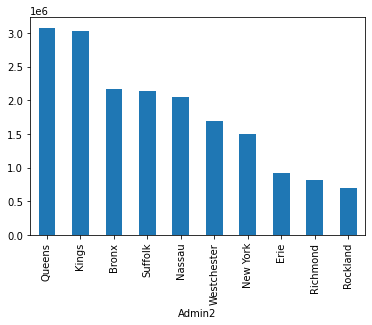

In [17]:
df_newyork1.groupby("Admin2").total_confirmed_cases.mean().sort_values(ascending=False)[:10].plot.bar()

### Define Foursquare Crediantials and Version
#### Next, we are going to start utilizing the foursquare API to explore the neighborhoods and segment them
Foursquare data is very comprehensive and it powers location data for Apple,Uber etc. For this business problem I have used, as a part of the assignment, the Foursquare API to retrieve information about the popular spots around these 10 major counties of New York. The popular spots returned depends on the time when call is made. So we may get different popular venues depending upon different time of the day. The call returns JSON file and we need to turn that into a dataframe.Here I've chosen 100 popular spots for each major counties within a radius of 9 km. Below is the dataframe obtained from the JSON file that was returned by Foursquare-

In [18]:
CLIENT_ID = 'NQPEPRVFDL5LXSC43ZBUQDOQWWRJJRKAQZ55URLJ3EEHWBZM' # your Foursquare ID
CLIENT_SECRET = 'BKSZMKRPOJPROUWSFMZ4UKZDI5GCAO2LUYVU0ARG0VGYUPL5' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100 
radius = 1000
#FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NQPEPRVFDL5LXSC43ZBUQDOQWWRJJRKAQZ55URLJ3EEHWBZM
CLIENT_SECRET:BKSZMKRPOJPROUWSFMZ4UKZDI5GCAO2LUYVU0ARG0VGYUPL5


### Methodology:
As a first step, we retrieved the data from FourSquare APIs. We extract venue information from the centre of New York upto 1000m. The latitude and lontitude values are used to fetch venue details. From the JSON file, we get responses of different venues with their names, categories, latitude and longitude. Then we combine our New York dataset with the venues extracted from the  Four Square. Next, we'll analyse the data that we created based on the counties with highly confirmed cases of covid-19. We'll identify the frequency of places where there is a lot of foot traffic. Afterwards, we explore the venue categories by plotting the bar graph to see which categories has the most foot traffic and categories which has the least visit by New Yorkers. Lastly, we'll cluster the venue categories based on the available information of each venue. This will allow us to clearly identify which venues could be the reason in this spread and with what characteristics.

In [19]:
def category_venues_Admin2(radius):

    df_venues = getNearbyVenues(radius,names=df_newyork1["Admin2"],
                                   latitudes=df_newyork1['Lat'],
                                   longitudes=df_newyork1['Long_']
                                  )

    return df_venues

In [20]:
def getNearbyVenues(r, names, latitudes, longitudes):

    radius=100
    LIMIT=100
    venues_names_list = []
    venues_categories_list = []
    venues_lat_list = []    
    venues_long_list = []
    county_list=[]
    latitude_list=[]
    longitude_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
    # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,lat,lng,VERSION,radius, LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['venues']

        
        for v in results:
            if len(v['categories']) > 0:
                county_list.append(name)
                latitude_list.append(lat)
                longitude_list.append(lng)
                venues_names_list.append(v['name'])
                venues_categories_list.append(v['categories'][0]['name'])
                venues_lat_list.append(v['location']['lat'])
                venues_long_list.append(v['location']['lng'])
   

    nearby_venues = pd.DataFrame({'Admin2':county_list,'Admin2_lat':latitude_list,'Admin2_long':longitude_list,'names':venues_names_list, 'categories':venues_categories_list,'lat':venues_lat_list,'long':venues_long_list})
    return(nearby_venues)

In [21]:
df_newyork_venue=category_venues_Admin2(radius)
df_newyork_venue

,Admin2,Admin2_lat,Admin2_long,names,categories,lat,long
0,Queens,40.710881,-73.816847,The Dungeon,Parking,40.711601,-73.816689
1,Queens,40.710881,-73.816847,MTA Subway - Briarwood (E/F),Metro Station,40.708848,-73.819872
2,Queens,40.710881,-73.816847,Shah's Halal Food @ Briarwood,Food Truck,40.709524,-73.819130
3,Queens,40.710881,-73.816847,Chui's Garden,Asian Restaurant,40.711207,-73.808881
4,Queens,40.710881,-73.816847,"MTA NYCT - Q20A, Q20B, Q44 (Main Street/Manton...",Bus Stop,40.709914,-73.818998
...,...,...,...,...,...,...,...
880,Rockland,41.150279,-74.025605,Packaging Express Plus,Post Office,41.149064,-74.021054
881,Rockland,41.150279,-74.025605,Rockland Thoracic & Vascular Assoc.,Doctor's Office,41.150244,-74.034846
882,Rockland,41.150279,-74.025605,Partners in Pediatrics,Doctor's Office,41.150555,-74.033882
883,Rockland,41.150279,-74.025605,Pediatric Associates,Doctor's Office,41.150555,-74.033882


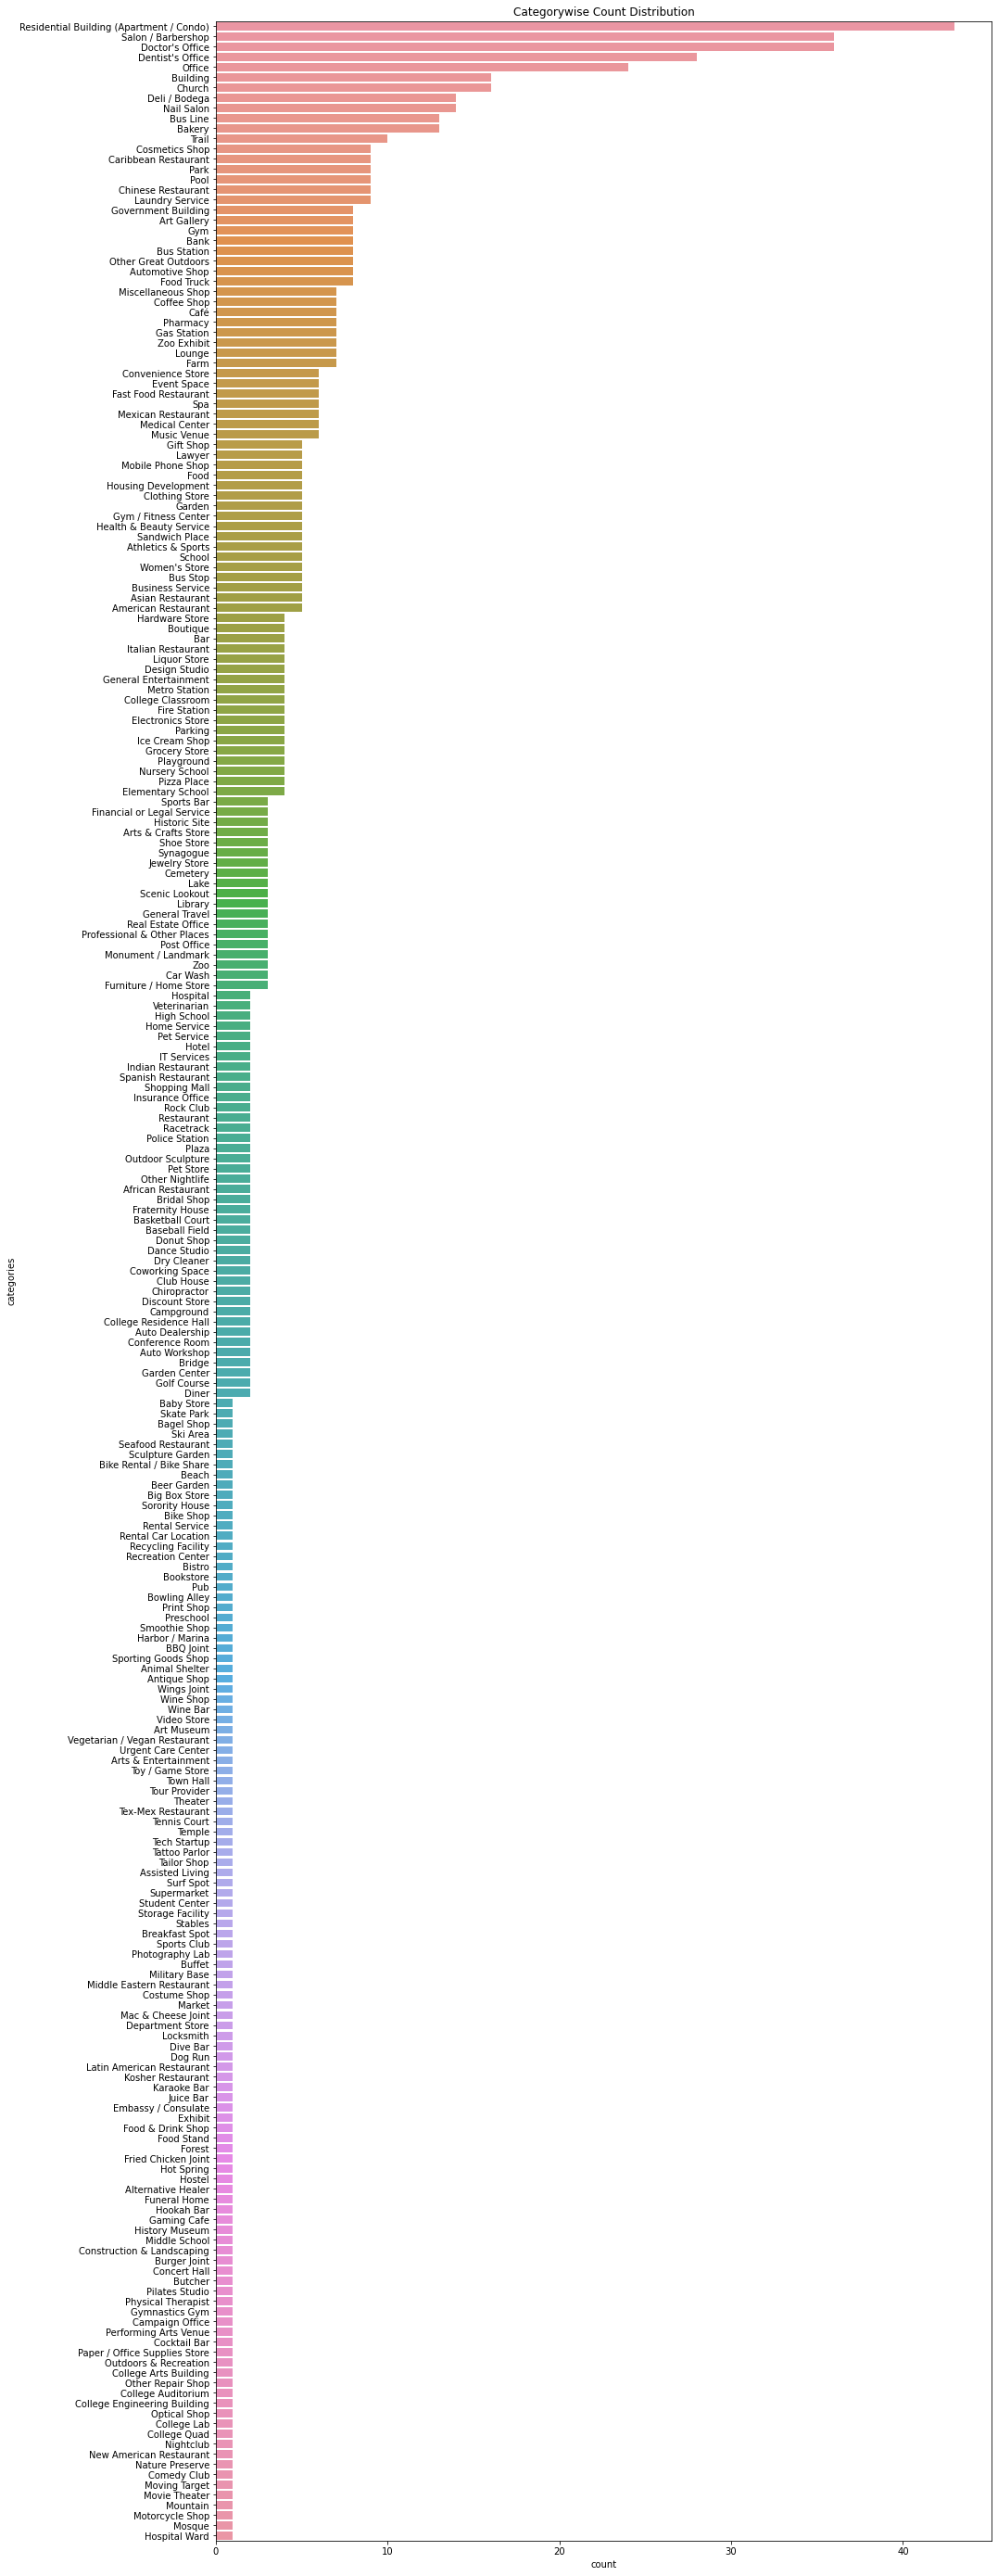

In [22]:
cat = df_newyork_venue.groupby('categories').count()
cat = cat['Admin2'].to_frame().reset_index(drop=False).sort_values(by="Admin2", ascending=False)
cat.rename({'Admin2': 'count'}, axis=1, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 50))
ax = sns.barplot(x="count", y="categories", data=cat)
plt.title("Categorywise Count Distribution")
plt.show()

## Analysis:
### Most Venues
We have different types of venues in each county of New york. We will take a look at the Counties(Admin2) and check which county has the majority of venues with theor count.

In [23]:
df_newyork_venue.groupby('Admin2').count()

,Admin2_lat,Admin2_long,names,categories,lat,long
Admin2,,,,,,
Bronx,93,93,93,93,93,93
Erie,92,92,92,92,92,92
Kings,92,92,92,92,92,92
Nassau,94,94,94,94,94,94
New York,95,95,95,95,95,95
Queens,87,87,87,87,87,87
Richmond,69,69,69,69,69,69
Rockland,85,85,85,85,85,85
Suffolk,94,94,94,94,94,94


From the result, we can see that New York has most values in the list and their boroughs like Bronx, kings has the venue count near to it.So, from this data, we can predict that New York and their boroughs has the most venues and it could be the centre of disaster.

## One hot Encoding: 
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [24]:
newyork_onehot = pd.get_dummies(df_newyork_venue[['categories']], prefix = "", prefix_sep="")
newyork_onehot

,African Restaurant,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Urgent Care Center,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
newyork_onehot.insert(loc=0,column ='Admin2', value=df_newyork_venue['Admin2'])
newyork_onehot

,Admin2,African Restaurant,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Urgent Care Center,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo,Zoo Exhibit
0,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Rockland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881,Rockland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
882,Rockland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,Rockland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
newyork_grouped = newyork_onehot.groupby('Admin2').mean().reset_index()
newyork_grouped.head()


,Admin2,African Restaurant,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Urgent Care Center,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo,Zoo Exhibit
0,Bronx,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.010753,0.000000,0.0,0.0,0.010753,0.0,0.000000,0.010753,0.000000,0.000000
1,Erie,0.000000,0.0,0.010870,0.01087,0.0,0.000000,0.000000,0.000000,0.01087,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.010870,0.000000,0.000000
2,Kings,0.021739,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Nassau,0.000000,0.0,0.021277,0.00000,0.0,0.000000,0.010638,0.010638,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.010638,0.000000,0.000000,0.000000
4,New York,0.000000,0.0,0.000000,0.00000,0.0,0.063158,0.000000,0.000000,0.00000,...,0.000000,0.010526,0.0,0.0,0.000000,0.0,0.000000,0.010526,0.031579,0.073684


In [27]:
num_top_venues = 5

for hood in newyork_grouped['Admin2']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Admin2'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bronx----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.08
1                           Doctor's Office  0.05
2                             Deli / Bodega  0.05
3                        Mexican Restaurant  0.04
4                                Nail Salon  0.03


----Erie----
                venue  freq
0    Dentist's Office  0.11
1  Salon / Barbershop  0.07
2                Bank  0.04
3              Lawyer  0.03
4              Church  0.03


----Kings----
                  venue  freq
0    Salon / Barbershop  0.14
1  Caribbean Restaurant  0.10
2              Bus Line  0.07
3       Automotive Shop  0.03
4    Chinese Restaurant  0.03


----Nassau----
                                      venue  freq
0                                    Office  0.11
1                           Doctor's Office  0.04
2  Residential Building (Apartment / Condo)  0.03
3                       Government Building  0.02
4                           Automotive S

Now, we are looking into the top 5 most common venues of each county(Admin2) and the frequency of visitors in each category. This would be a great step to visualize except resturants and bars which other categories contributing to Covid-19 spiking in beginning of this pandemic.
Next, we will merge these common venues with NewYork data contains county(Admin2), latitude, longitude to see the top 10 common venues in each county.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending =False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
import numpy as np

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Admin2']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
            columns.append('{}th Most Common Venue'.format(ind+1))
            
            
# create a new dataframe
newyork_venues_sorted = pd.DataFrame(columns = columns)
newyork_venues_sorted['Admin2'] = newyork_grouped['Admin2']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_venues_sorted.iloc[ind,1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)
    
    
newyork_venues_sorted.head()

,Admin2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
1,Erie,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery
2,Kings,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
3,Nassau,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports
4,New York,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building


Now, I have decided to make 5 clusters of the above dataset by using kMeans clustering and decided to cluster the venues into seperate groups.

In [31]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Admin2', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(newyork_grouped_clustering)

#check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 4, 2, 1, 1, 3, 3, 3, 0], dtype=int32)

In [32]:
#add clustering labels
newyork_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)
newyork_merged = df_newyork_venue

#merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
newyork_merged = newyork_merged.join(newyork_venues_sorted.set_index('Admin2'), on ='Admin2')
newyork_merged.head()


,Admin2,Admin2_lat,Admin2_long,names,categories,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,40.710881,-73.816847,The Dungeon,Parking,40.711601,-73.816689,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
1,Queens,40.710881,-73.816847,MTA Subway - Briarwood (E/F),Metro Station,40.708848,-73.819872,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
2,Queens,40.710881,-73.816847,Shah's Halal Food @ Briarwood,Food Truck,40.709524,-73.819130,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
3,Queens,40.710881,-73.816847,Chui's Garden,Asian Restaurant,40.711207,-73.808881,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
4,Queens,40.710881,-73.816847,"MTA NYCT - Q20A, Q20B, Q44 (Main Street/Manton...",Bus Stop,40.709914,-73.818998,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue


In [33]:
newyork_venues_sorted

,Cluster Label,Admin2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Bronx,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
1,0,Erie,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery
2,4,Kings,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
3,2,Nassau,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports
4,1,New York,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building
5,1,Queens,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
6,3,Richmond,Doctor's Office,Trail,Pool,Gym / Fitness Center,Park,Bus Stop,Campground,Bakery,Fast Food Restaurant,Art Gallery
7,3,Rockland,Doctor's Office,Church,Medical Center,Salon / Barbershop,Government Building,Elementary School,Bus Station,Miscellaneous Shop,Dentist's Office,Bakery
8,3,Suffolk,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
9,0,Westchester,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail


In [34]:
address = 'New York, CA'

geolocator = Nominatim(user_agent= "ny_explorer")##
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of NewYork are {} {}.'. format(latitude,longitude))


The geographical coordinate of NewYork are 34.0143928 -117.898451.


### Cluster Visualization:
It is good for us to see the map of the 9 clusters so we can know visually the geographical distribution of all clusters.

In [35]:
# create map
map_clusters = folium.Map(location=[34.0143928, -117.898451],zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, log, admin2, cluster in zip(newyork_merged['Admin2_lat'], newyork_merged['Admin2_long'], newyork_merged['Admin2'], newyork_merged['Cluster Label']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, log],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
newyork_merged.loc[newyork_merged['Cluster Label']==0, newyork_merged.columns[[0] + list(range(5,newyork_merged.shape[1]))]]

,Admin2,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
460,Westchester,41.165475,-73.761083,0,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail
461,Westchester,41.160070,-73.764755,0,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail
462,Westchester,41.158084,-73.765372,0,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail
463,Westchester,41.160845,-73.771548,0,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail
464,Westchester,41.162918,-73.765554,0,Salon / Barbershop,Nail Salon,Car Wash,College Classroom,Doctor's Office,Church,Music Venue,Deli / Bodega,Dentist's Office,Trail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,Erie,42.765397,-78.745858,0,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery
727,Erie,42.767890,-78.743078,0,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery
728,Erie,42.767315,-78.744720,0,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery
729,Erie,42.762314,-78.741089,0,Dentist's Office,Salon / Barbershop,Bank,Church,Lawyer,Boutique,Design Studio,Nursery School,Office,Cemetery


In [37]:
newyork_merged.loc[newyork_merged['Cluster Label']==1, newyork_merged.columns[[0] + list(range(5,newyork_merged.shape[1]))]]

,Admin2,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,40.711601,-73.816689,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
1,Queens,40.708848,-73.819872,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
2,Queens,40.709524,-73.819130,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
3,Queens,40.711207,-73.808881,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
4,Queens,40.709914,-73.818998,1,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Office,Salon / Barbershop,Building,Bus Line,Playground,Grocery Store,Music Venue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,New York,40.765526,-73.971806,1,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building
635,New York,40.765530,-73.971970,1,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building
636,New York,40.767768,-73.971841,1,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building
637,New York,40.766207,-73.970418,1,Residential Building (Apartment / Condo),Zoo Exhibit,Art Gallery,Dentist's Office,Doctor's Office,Building,Café,Zoo,Monument / Landmark,Government Building


In [38]:
newyork_merged.loc[newyork_merged['Cluster Label']==2, newyork_merged.columns[[0] + list(range(5,newyork_merged.shape[1]))]]

,Admin2,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
179,Bronx,40.854322,-73.860423,2,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
180,Bronx,40.858740,-73.855608,2,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
181,Bronx,40.852228,-73.864667,2,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
182,Bronx,40.854651,-73.864156,2,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
183,Bronx,40.852228,-73.864667,2,Residential Building (Apartment / Condo),Deli / Bodega,Doctor's Office,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant,Dentist's Office,Bakery,Nail Salon,Salon / Barbershop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,Nassau,40.745392,-73.587494,2,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports
456,Nassau,40.745106,-73.590263,2,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports
457,Nassau,40.743728,-73.589568,2,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports
458,Nassau,40.736492,-73.588930,2,Office,Doctor's Office,Residential Building (Apartment / Condo),Gym,Auto Workshop,Furniture / Home Store,Pool,Bridal Shop,Home Service,Athletics & Sports


In [39]:
newyork_merged.loc[newyork_merged['Cluster Label']==3, newyork_merged.columns[[0] + list(range(5,newyork_merged.shape[1]))]]

,Admin2,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
272,Suffolk,40.874628,-72.808452,3,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
273,Suffolk,40.915315,-72.790510,3,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
274,Suffolk,40.860096,-72.808850,3,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
275,Suffolk,40.868102,-72.794711,3,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
276,Suffolk,40.907026,-72.795367,3,Farm,Food Truck,Other Great Outdoors,Bus Station,Lake,Trail,Doctor's Office,Park,Convenience Store,Nail Salon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Rockland,41.149064,-74.021054,3,Doctor's Office,Church,Medical Center,Salon / Barbershop,Government Building,Elementary School,Bus Station,Miscellaneous Shop,Dentist's Office,Bakery
881,Rockland,41.150244,-74.034846,3,Doctor's Office,Church,Medical Center,Salon / Barbershop,Government Building,Elementary School,Bus Station,Miscellaneous Shop,Dentist's Office,Bakery
882,Rockland,41.150555,-74.033882,3,Doctor's Office,Church,Medical Center,Salon / Barbershop,Government Building,Elementary School,Bus Station,Miscellaneous Shop,Dentist's Office,Bakery
883,Rockland,41.150555,-74.033882,3,Doctor's Office,Church,Medical Center,Salon / Barbershop,Government Building,Elementary School,Bus Station,Miscellaneous Shop,Dentist's Office,Bakery


In [40]:
newyork_merged.loc[newyork_merged['Cluster Label']==4, newyork_merged.columns[[0] + list(range(5,newyork_merged.shape[1]))]]

,Admin2,lat,long,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Kings,40.636325,-73.950624,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
88,Kings,40.636147,-73.947695,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
89,Kings,40.635444,-73.950537,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
90,Kings,40.635308,-73.950267,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
91,Kings,40.639942,-73.955490,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Kings,40.636032,-73.946587,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
175,Kings,40.636877,-73.952351,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
176,Kings,40.634342,-73.947662,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store
177,Kings,40.634672,-73.947608,4,Salon / Barbershop,Caribbean Restaurant,Bus Line,Event Space,Church,Lounge,Food,Chinese Restaurant,Automotive Shop,Shoe Store


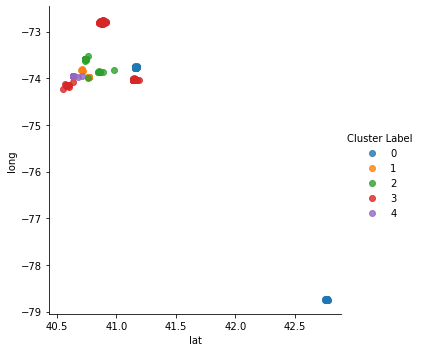

In [53]:

facet = sns.lmplot(data= newyork_merged, x='lat', y='long', hue='Cluster Label', 
                   fit_reg=False, legend=True, legend_out=True)

## Result And Discussion
From the cluster Analysis, we can clearly see that the top most venue categories of each county where people frequently visit. From the cluster 0, we can see Salon/Barbershop, nail shops and dentist offices, college classroom have alot of foot traffic. Also, the nature of the business conducted at these work cites is something where social distance is quite not possible. Another similar place with social distancing issues is college classroom and Doctor’s office, as the one person alone can be the source of the virus spread to many people. This can also make contact tracing very difficult.


## Cluster1:
Cluster 1 shows people in New York frequently visit residential buildings/condo, which is the main cause of spreading this virus. The majority of New York City residents live in apartments — in close quarters with neighbours above, below and on either side. And that has added to the challenges of the spread of COVID-19 in the five boroughs and counties of New York. Moreover, close proximity of relatives & friends of the tenants of residential buildings with each other would be another reason. The second most common venue is Deli, we find a lot of foot traffic in these shops too.


## Cluster 2:
Cluster 2 again shows salon/Barbershop is the most common venue in the given latitude and longitudes. The second most common venues are restaurants and food in general. As we know, in Salon/barbershop, it's very hard to maintain distance and virus can easily be transmitted from one person to another. Food trucks and restaurants have chefs and as we already explained earlier, if chef is infected, then he can infect all his customers.

## Cluster 3:
Cluster 3 shows different common venues for different counties. In Suffolk, common venues are Farm, food truck, other great outdoors and bus station whereas in Rockland, Doctor's office, church, Salon/Barbershop and Hospitals are common venues. As we know, in Salon/barbershop, it's very hard to maintain distance and virus can easily be transmitted from one person to another. Food trucks have chefs and as we already explained earlier, if chef is infected, then he can infect all his customers.

## Cluster 4:
Cluster 4 shows only one county that is kings where the most common venues are residential buildings/condo, Restaurants, doctor’s office and Food. All these venues have high foot traffic and these are the places where the virus can be easily transmitted because people are in close proximity of each other. It is difficult for one to prevent themselves from getting infected at these crowded places. Because of the preventative measures taken by doctors and employees, the chances of spreading this virus is reduced. But people working over there and patients visiting on regular basis are still prone to getting infected.



## Discussion:
From our analysis, we noticed that some venues are quite common for visitations across all counties of New York particularly residential buildings/condo, barbershops, Nail salons, Deli and restaurants. This analysis gives us the answer of an article mentioned above in the beginning which outlined the missing top four categories while the restaurants and bars fall under the fifth and sixth category of virus spread. Some challenges I have faced while running the Four-square API are that it gives us only venue information from which I can anticipate that these top common venues in each county could be the reason of rapid spread of covid-19. In New York dataset I have access to only confirmed cases of each county instead of each neighbourhood of New York. If I had more information regarding neighbourhoods of New York city then I can construct a better k-Means model. Moreover, if I could have more data regarding neighbourhoods of New York then I could clearly see from the analysis, which areas are more affected in each borough.


## Conclusion
 The purpose of this project was to explore the most affected counties of New York and to get the rough idea of which places this virus has spread. Nothing has fostered the increase of Covid-19 spread more than private family gatherings according to cluster analysis. We can clearly see residential buildings/condo are quite common in each cluster. One of the limitations of this project was that I have confirmed cases of only counties and New York boroughs. However, each borough and county are quite big in size and needs to be broken down to neighbourhoods to get a more accurate representation, but total confirmed covid-19 cases of neighbourhoods of each borough were not available for New York. In this way, it's hard to find out the most affected residential neighbourhoods, but, if I were able to extract contact tracing data then I would be able to make clusters of highly affected residential areas.
 
After merging data from the Four-Square API, I have the performed EDA to reveal a few interesting observations and I have also performed K means clustering on the data set based on different counties confirmed cases. It revealed us possible hotspots for the spread of virus. After attempting the one-hot encoding, I can see top 5 venues of each county with frequency of visitors. Furthermore, the clustering exercises highlighted the group of optimal areas and gives us the glimpse into reason of spreading this virus rapidly.
